# Analysis for project 1

Run PCA, MDS, t-SNE, and UMAP on TCGA gene expression data. Inspect variation of metadata features across reduced dimensions.

In [1]:
import numpy as np
import pandas as pd
from anndata import AnnData
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale

# import embedding functions
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from umap import UMAP

/Users/mcuoco/projects/ece204_project1/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read and clean the data

In [2]:
# read expression data
expr = pd.read_csv('data/TCGA.HNSC.expression.txt', sep='\t', header=0, index_col=[0,1])
print("expression data shape: ", expr.shape)
expr.head()[0:5]

expression data shape:  (545, 20531)


,,?|100130426,?|100133144,?|100134869,?|10357,?|10431,?|136542,?|155060,?|26823,?|280660,?|317712,...,ZWILCH|55055,ZWINT|11130,ZXDA|7789,ZXDB|158586,ZXDC|79364,ZYG11A|440590,ZYG11B|79699,ZYX|7791,ZZEF1|23140,ZZZ3|26009
patient_id,sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,TCGA-4P-AA8J-01A-11R-A39I-07,0.0,3.1490,12.8732,122.939,1429.060,0.0,266.2150,0.0000,0.0,0.0,...,281.861,695.116,24.6495,150.362,732.091,7.3949,419.042,11611.80,881.220,358.650
TCGA-BA-4074,TCGA-BA-4074-01A-01R-1436-07,0.0,12.8563,11.8081,336.165,1927.680,0.0,39.3089,0.0000,0.0,0.0,...,2132.460,1193.140,23.8937,172.266,380.372,4.6246,805.062,2516.93,258.591,1088.320
TCGA-BA-4075,TCGA-BA-4075-01A-01R-1436-07,0.0,12.3168,3.7626,347.812,1492.700,0.0,77.7167,0.0000,0.0,0.0,...,761.002,673.188,20.9031,172.049,562.240,1.6079,487.740,5930.05,292.644,980.303
TCGA-BA-4076,TCGA-BA-4076-01A-01R-1436-07,0.0,12.4833,4.3080,278.017,1205.820,0.0,112.2920,0.5247,0.0,0.0,...,480.068,1032.660,47.2255,324.282,1440.900,35.1568,722.550,2674.54,672.176,998.557
TCGA-BA-4077,TCGA-BA-4077-01B-01R-1436-07,0.0,12.4543,11.6073,321.545,853.706,0.0,48.1232,0.0000,0.0,0.0,...,1325.310,1620.310,44.7546,210.780,1423.000,52.9355,770.934,8035.61,763.234,692.974


In [3]:
# read meta data
meta = pd.read_csv('data/TCGA.HNSC.metadata.txt', sep='\t', header=0, index_col=0)
print("meta data shape: ", meta.shape)
meta.head()

meta data shape:  (500, 18)


,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
patient_id,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,HNSC,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Alive,0.0,102.0,0.0,102.0,NaN,NaN,0.0,102.0,NaN
TCGA-BA-4074,HNSC,69.0,MALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,WITH TUMOR,Dead,1.0,462.0,1.0,462.0,NaN,NaN,1.0,396.0,NaN
TCGA-BA-4075,HNSC,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,283.0,1.0,283.0,NaN,NaN,1.0,236.0,NaN
TCGA-BA-4076,HNSC,39.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,415.0,1.0,415.0,NaN,NaN,1.0,286.0,NaN
TCGA-BA-4077,HNSC,45.0,FEMALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,1134.0,1.0,1134.0,NaN,NaN,1.0,1134.0,NaN


In [4]:
# get meta data per sample
meta = expr.reset_index()[['patient_id','sample_id']].join(meta, on='patient_id').set_index(['patient_id','sample_id'])
print("meta data shape: ", meta.shape)
meta.head()

meta data shape:  (545, 18)


,,type,age_at_initial_pathologic_diagnosis,gender,race,ajcc_pathologic_tumor_stage,histological_type,histological_grade,tumor_status,vital_status,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
patient_id,sample_id,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,TCGA-4P-AA8J-01A-11R-A39I-07,HNSC,66.0,MALE,BLACK OR AFRICAN AMERICAN,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,TUMOR FREE,Alive,0.0,102.0,0.0,102.0,NaN,NaN,0.0,102.0,NaN
TCGA-BA-4074,TCGA-BA-4074-01A-01R-1436-07,HNSC,69.0,MALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G3,WITH TUMOR,Dead,1.0,462.0,1.0,462.0,NaN,NaN,1.0,396.0,NaN
TCGA-BA-4075,TCGA-BA-4075-01A-01R-1436-07,HNSC,49.0,MALE,BLACK OR AFRICAN AMERICAN,Stage III,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,283.0,1.0,283.0,NaN,NaN,1.0,236.0,NaN
TCGA-BA-4076,TCGA-BA-4076-01A-01R-1436-07,HNSC,39.0,MALE,WHITE,[Not Available],Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,415.0,1.0,415.0,NaN,NaN,1.0,286.0,NaN
TCGA-BA-4077,TCGA-BA-4077-01B-01R-1436-07,HNSC,45.0,FEMALE,WHITE,Stage IVA,Head & Neck Squamous Cell Carcinoma,G2,WITH TUMOR,Dead,1.0,1134.0,1.0,1134.0,NaN,NaN,1.0,1134.0,NaN


We have 545 samples from 500 patients. 20531 features (genes) were quantified from each sample

## Inspect mean-variance relationship of features

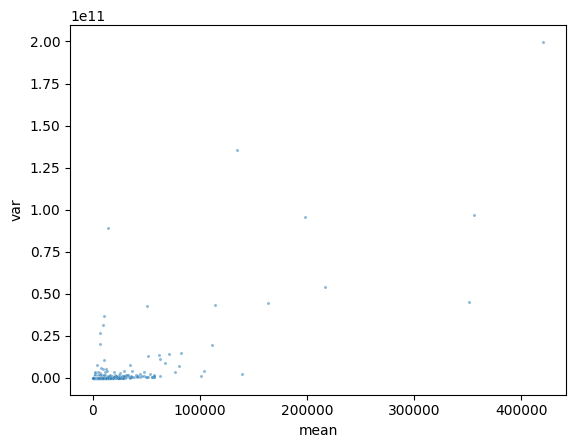

In [5]:
mean_var = pd.DataFrame()
mean_var['mean'] = expr.mean(axis=0)
mean_var['var'] = expr.var(axis=0)
f = sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)

[None, None]

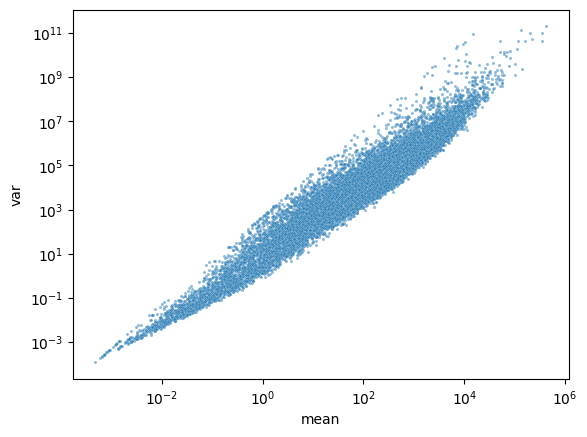

In [6]:
# log transform axes to see more clearly
f = sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)
f.set(xscale="log", yscale="log")

Data is heteroscedastic. We will need to stabilize the variance of the data before proceeding.

<Axes: xlabel='mean', ylabel='var'>

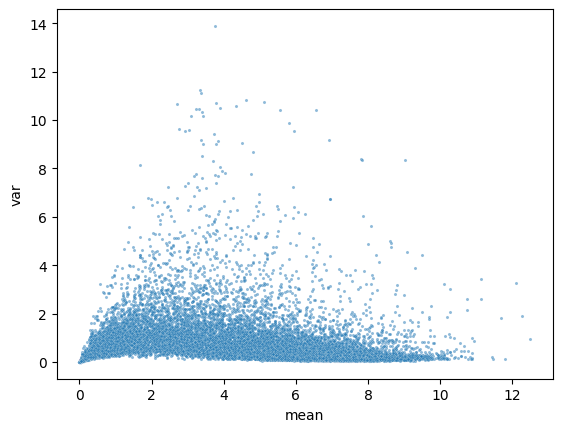

In [7]:
# log1p transform expression data (can't use log because of zeros)
expr_norm = expr.apply(lambda x: np.log1p(x), axis=0)
mean_var['mean'] = expr_norm.mean(axis=0)
mean_var['var'] = expr_norm.var(axis=0)
sns.scatterplot(data=mean_var, x='mean', y='var', s = 5, alpha=0.5)

## Normalize, scale, center, and embed the data

In [99]:
# put into Annotated Data object for nice organization
adata = AnnData(expr, obs=meta, var=expr.columns.to_frame(name='gene'), dtype=np.float32)

# remove zeros
adata = adata[:, adata.X.sum(axis=0) > 0]

# log(x+1) transform each value in matrix
adata.X_normed = np.log1p(adata.X)

# scale only, don't center (PCA centers internally)
adata.X_scaled = scale(adata.X_normed, with_mean=False, axis = 1)

# scale and center
adata.X_standardized = scale(adata.X_normed, with_mean=True, axis=1)

# embed data
# PCA
print("Running PCA...")
adata.obsm["pca"] = PCA().fit_transform(adata.X_scaled)

# MDS
print("Running MDS...")
adata.obsm["mds"] = MDS(normalized_stress='auto').fit_transform(adata.X_standardized)

# t-SNE
print("Running t-SNE...")
adata.obsm["tsne"] = TSNE().fit_transform(adata.X_standardized)

# UMAP
print("Running UMAP...")
adata.obsm["umap"] = UMAP().fit_transform(adata.X_standardized)

KeyError: 'mds'

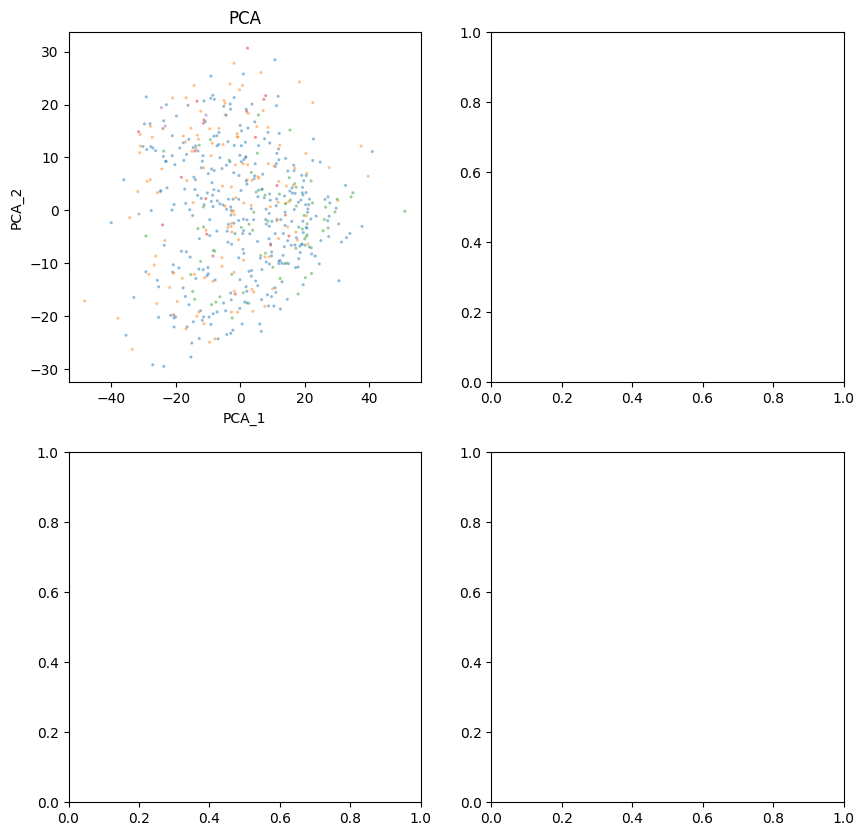

In [101]:
# setup 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(10,10))
for i, method in enumerate(['pca', 'mds', 'tsne', 'umap']):
	# get embedding
	embedding = adata.obsm[method]
	method = method.upper()
	
	# plot embedding
	sns.scatterplot(x=embedding[:,0], y=embedding[:,1], s=5, alpha=0.5, hue=adata.obs['histological_grade'], ax=axs[int(i/2), i%2])
	axs[int(i/2), i%2].set_title(method)
	axs[int(i/2), i%2].set(xlabel=method+'_1', ylabel=method+'_2')

	# hide legend
	axs[int(i/2), i%2].legend_.remove()

In [ ]:
adata._sanitize() # Transform string annotations to categoricals.
adata.write_h5ad('data/TCGA.HNSC.embedded.h5ad')